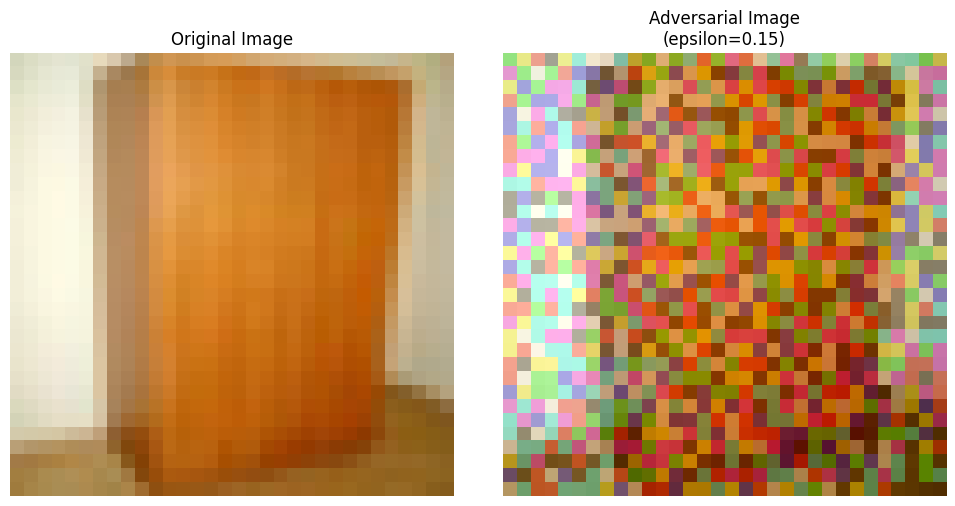

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 1. Load CIFAR-100 test dataset
transform = transforms.Compose([transforms.ToTensor()])
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform) # Changed to CIFAR100
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

# 2. Define a simple CNN (modified for CIFAR-100)
class SimpleCNN(nn.Module):
    def __init__(self): # Changed _init_ to __init__
        super(SimpleCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256), nn.ReLU(),
            nn.Linear(256, 100)  # Changed output to 100 for CIFAR-100
        )

    def forward(self, x):
        return self.model(x)

model = SimpleCNN()
model.eval()

# 3. FGSM Attack Function (Modified to decrease pixel values)
def fgsm_attack(image, label, model, epsilon):
    image.requires_grad = True
    output = model(image)
    loss = nn.CrossEntropyLoss()(output, label)

    model.zero_grad()
    loss.backward()
    data_grad = image.grad.data
    perturbed_image = image - epsilon * data_grad.sign()  # Subtracting perturbation
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

# 4. Load one sample image
dataiter = iter(testloader)
images, labels = next(dataiter)

original_image = images.clone()
epsilon = 0.15
adv_image = fgsm_attack(images, labels, model, epsilon)

# 5. Visualization function
def imshow(img, title):
    img = img.squeeze().detach().cpu().numpy()
    img = img.transpose((1, 2, 0))
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# 6. Plot Original and Adversarial Images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
imshow(original_image, "Original Image")
plt.subplot(1, 2, 2)
imshow(adv_image, f"Adversarial Image\n(epsilon={epsilon})")
plt.tight_layout()
plt.show()